**Deep Learning for Natural Language Processing: Homework 2**

> Eirini Kolimatsi \
> MSc Computer Science, University of Athens \
>
> **Email**: eirini [dot] kolimatsi [at] di [dot] uoa [dot] gr \
> **Student ID**: 7115112200015

## Libraries & Connection
<a name="libraries"></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Colab Notebooks/data/imdb-reviews.csv'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
from itertools import product
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

!pip install contractions
import contractions
!pip install pyspellchecker
from spellchecker import SpellChecker

# NLTK imports
import nltk
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer

# pytorch imports
import torchtext
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 27.5 MB/s 
     |████████████████████████████████| 110 kB 72.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 41.2 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Runing on: ", device)

Runing on:  cuda


## Data Loading & Preparation

### Functions for data preparation
<a name="dataprep"></a>

In [ ]:
glove = torchtext.vocab.GloVe(name="6B", dim=50)

.vector_cache/glove.6B.zip: 862MB [02:41, 5.35MB/s]                           
100%|█████████▉| 399999/400000 [00:09<00:00, 43212.60it/s]


In [ ]:
glove300 = torchtext.vocab.GloVe(name="6B", dim=300)

100%|█████████▉| 399999/400000 [00:52<00:00, 7553.84it/s] 


In [ ]:
# Helpers

# Contractions distionary
contractions_dict = {k.lower(): v for k, v in contractions.contractions_dict.items()}

# Spellchecking: if the typo can't be fixed then do nothing (by default it would return None)
skip_unresolved = lambda fix, typo: fix if fix else typo

In [ ]:
def clean_text(text,remove_contractions=True,remove_html_tags=True,remove_punctuation=True,remove_stopwords=True,reduce_length=True,spellchecking=True):

  # lower case
  text = text.lower()

  # remove contractions
  if remove_contractions:
    for key in contractions_dict:
              text = text.replace('\b'+key+'\b', contractions_dict[key])

  # Remove html tags
  if remove_html_tags:
    text = re.sub('<[^>]*>', '', text)

  # Remove punctuation
  if remove_punctuation:
    punc = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text) + ' '.join(punc).replace('-', '')
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
  
  # Reduce length in cases of multiple letters eg mistaaaaakesssss
  if reduce_length:
    pattern = re.compile(r"(.)\1{2,}")
    text = ' '.join([pattern.sub(r"\1\1", word) for word in text.split()])

  # Remove stopwords
  if remove_stopwords:
    stop = stopwords.words('english')
    stop.extend(['movie','film','one','like','would'])
    text = ' '.join([word for word in text.split() if word not in (stop)])
  
  # Remove multiple spaces
  text = re.sub(r' +',' ',text).strip()

  # Spelling fixes
  if spellchecking:
    spelling = SpellChecker()
    # words with typos are selected taking into consideration the embeddings
    # if a word is a typo but exists in glove embeddings then it isn't fixed
    words = text.split()
    typo_words = {tw:spelling.correction(tw) for tw in spelling.unknown(words) if tw not in glove.itos}
    text = ' '.join([skip_unresolved(spelling.correction(word),word) if word in typo_words else word for word in words])

  return text.strip()

In [ ]:
# Load and prep dataset
def prep_data(data_path):
  df = pd.read_csv(data_path, sep='\t')
  df['review'] = df['review'].progress_apply(clean_text, spellchecking=False)

  df.drop(['url'], axis=1, inplace=True)

  df.loc[df['rating'] <= 4, 'rating'] = 0
  df.loc[df['rating'] >= 7, 'rating'] = 1
  return df

In [ ]:
# Calculate embeddings
def glovify(row, glove=glove, dim=50):
  splited_words = row.str.split(' ')[0]
  weight_matrix = np.zeros((len(splited_words),dim))
  for j, word in enumerate(splited_words): 
    if word in glove.itos:
      weight_matrix[j] = glove[word]
  return np.array(np.mean(weight_matrix,axis=0))

def glovify300(row, glove=glove300, dim=300):
  splited_words = row.str.split(' ')[0]
  weight_matrix = np.zeros((len(splited_words),dim))
  for j, word in enumerate(splited_words): 
    if word in glove.itos:
      weight_matrix[j] = glove[word]
  return np.array(np.mean(weight_matrix,axis=0))

  train_loader, val_loader, test_loader = None, None, None

### Data exploration

In [ ]:
df = prep_data(data_path)

100%|██████████| 45008/45008 [00:57<00:00, 785.04it/s]


In [ ]:
df['review'][4]

'really genuine random really hard find movies bunches movies hollywood really enjoy watching bought dvd tuesday week watched 4 times love spanglish accent paz really cute acting morgan funny natural taste might really different others say really love simple best learned something life well least usa life life really random sometimes u meet someone pass life friends coincidently u spend much time maybe u enjoy u never meet time u together really unforgettable keep moments mind grateful nice memories might cheap making price meanings totally cheap rarely learn anything movies exception'

In [ ]:
df['rating'].value_counts()

1.0    22508
0.0    22500
Name: rating, dtype: int64

In [ ]:
print('Mean review length:',np.mean(df['review'].apply(len)))
print('Median review length:',np.median(df['review'].apply(len)))
print('Max review length:',np.max(df['review'].apply(len)))
print('Min review length:',np.min(df['review'].apply(len)))

Mean review length: 792.5222182723071
Median review length: 578.0
Max review length: 9102
Min review length: 16


In [ ]:
X = df['review']
y = df['rating']

# Split dataset to train and test set. 90-10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

# Split train dataset to train and validation set. 80-10-10
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1/0.8, random_state=42, stratify=y_train)

print("Shape of x_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of x_val:  ", X_val.shape)
print("Shape of y_val:  ", y_val.shape)
print("Shape of x_test:  ", X_test.shape)
print("Shape of y_test:  ", y_test.shape)
print('---------------')
print('class counts of y_train: \n', y_train.value_counts())
print('class counts of y_val: \n', y_val.value_counts())
print('class counts of y_test: \n', y_test.value_counts())

Shape of x_train:  (35443,)
Shape of y_train:  (35443,)
Shape of x_val:   (5064,)
Shape of y_val:   (5064,)
Shape of x_test:   (4501,)
Shape of y_test:   (4501,)
---------------
class counts of y_train: 
 1.0    17725
0.0    17718
Name: rating, dtype: int64
class counts of y_val: 
 1.0    2532
0.0    2532
Name: rating, dtype: int64
class counts of y_test: 
 1.0    2251
0.0    2250
Name: rating, dtype: int64


### Prerare data for training

#### 50d GloVe Embeddings

In [ ]:
# Get average embbedding vector for each sentence
X_train_glove = pd.DataFrame(X_train).progress_apply(glovify, axis=1)
X_val_glove = pd.DataFrame(X_val).progress_apply(glovify, axis=1)
X_test_glove = pd.DataFrame(X_test).progress_apply(glovify, axis=1)

100%|██████████| 35443/35443 [19:25<00:00, 30.41it/s]


In [ ]:
X_train_glove

21358    [-0.026215241527097533, 0.42517279692687243, -...
22233    [0.05725079872260947, 0.008020867687272743, -0...
35870    [0.2955513553315541, 0.05720131981797749, -0.0...
25266    [0.26460839742794634, 0.1138897605612874, -0.0...
34262    [0.16456332183103464, 0.12211947333222876, -0....
                               ...                        
35495    [0.029222782045094806, 0.18060387376780537, -0...
19602    [0.07722165045360553, -0.19443931583122448, -0...
3196     [0.0766508812084794, -0.021973901714843053, -0...
44447    [0.08998913330054192, 0.11574864004893849, -0....
23367    [0.264816100994239, 0.10565682187162954, -0.01...
Length: 35443, dtype: object

In [ ]:
# X to tensor
X_train_final = torch.tensor(X_train_glove.to_list())
X_val_final = torch.tensor(X_val_glove.to_list())
X_test_final = torch.tensor(X_test_glove.to_list())

In [ ]:
# y to tensor
y_train_final = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
y_val_final = torch.squeeze(torch.from_numpy(y_val.to_numpy()).float())
y_test_final = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

In [ ]:
# pytorch dataset creation
train_set = TensorDataset(X_train_final, y_train_final)
validation_set = TensorDataset(X_val_final, y_val_final)
test_set = TensorDataset(X_test_final, y_test_final)

In [ ]:
# pytorch loaders creation
max_seq_len = 50
batch_size = 32

train_loader = DataLoader(train_set, batch_size= batch_size,
                                     shuffle= True)
val_loader = DataLoader(validation_set, batch_size= batch_size, 
                                    shuffle= False)
test_loader = DataLoader(test_set, batch_size= len(test_set), #batch_size, 
                                    shuffle= False)

#### 300d GloVe Embeddings

In [ ]:
# Get average embbedding vector for each sentence
X_train_glove300 = pd.DataFrame(X_train).progress_apply(glovify300, axis=1)
X_val_glove300 = pd.DataFrame(X_val).progress_apply(glovify300, axis=1)
X_test_glove300 = pd.DataFrame(X_test).progress_apply(glovify300, axis=1)

100%|██████████| 4501/4501 [02:07<00:00, 35.30it/s]


In [ ]:
# pytorch dataset & loaders creation
X_train_final300 = torch.tensor(X_train_glove300.to_list())
X_val_final300 = torch.tensor(X_val_glove300.to_list())
X_test_final300 = torch.tensor(X_test_glove300.to_list())

train_set300 = TensorDataset(X_train_final300, y_train_final)
validation_set300 = TensorDataset(X_val_final300, y_val_final)
test_set300 = TensorDataset(X_test_final300, y_test_final)

max_seq_len = 300
batch_size=32

train_loader300 = DataLoader(train_set300, batch_size= batch_size,
                                     shuffle= True)
val_loader300 = DataLoader(validation_set300, batch_size= batch_size, 
                                    shuffle= False)
test_loader300 = DataLoader(test_set300, batch_size= len(test_set300), #batch_size, 
                                    shuffle= False)

In [ ]:
# save pytorch datasets for fast use
save_path = '/content/drive/My Drive/Colab Notebooks/data/'
# 50 dim
for v,n in zip([train_set, validation_set, test_set],['tr_d_50','val_d_50','te_d_50']):
  torch.save(v, save_path+n+'.pt')

# 300 dim
for v,n in zip([train_set300, validation_set300, test_set300],['tr_d_300','val_d_300','te_d_300']):
  torch.save(v, save_path+n+'.pt')

In [ ]:
# load pytorch datasets
save_path = '/content/drive/My Drive/Colab Notebooks/data/'
batch_size = 32

# 50 dim
train_set=torch.load(save_path+'tr_d_50.pt')
validation_set=torch.load(save_path+'val_d_50.pt')
test_set=torch.load(save_path+'te_d_50.pt')

train_loader = DataLoader(train_set, batch_size= batch_size,
                                     shuffle= True)
val_loader = DataLoader(validation_set, batch_size= batch_size, 
                                    shuffle= False)
test_loader = DataLoader(test_set, batch_size= len(test_set), #batch_size, 
                                    shuffle= False)
# 300 dim
train_set300=torch.load(save_path+'tr_d_300.pt')
validation_set300=torch.load(save_path+'val_d_300.pt')
test_set300=torch.load(save_path+'te_d_300.pt')

train_loader300 = DataLoader(train_set300, batch_size= batch_size,
                                     shuffle= True)
val_loader300 = DataLoader(validation_set300, batch_size= batch_size, 
                                    shuffle= False)
test_loader300 = DataLoader(test_set300, batch_size= len(test_set300), #batch_size, 
                                    shuffle= False)

## Models

In [ ]:
# Model 1
class SentimentClassifier_2L(nn.Module):
    def __init__(self, input_size, hidden_size = 100, activation_fn = F.relu):
      
        super(SentimentClassifier_2L,self).__init__()
        
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.activation_fn = activation_fn

    def forward(self, x):
        out = self.activation_fn(self.linear1(x.to(torch.float32)))
        out = self.linear2(out)
        return out

In [ ]:
# Model 2
class SentimentClassifier_5L(nn.Module):
    def __init__(self, input_size, hidden_size = 512, activation_fn = F.relu):
      
        super(SentimentClassifier_5L,self).__init__()
        
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear3 = nn.Linear(int(hidden_size/2), int(hidden_size/4))
        self.linear4 = nn.Linear(int(hidden_size/4), int(hidden_size/8))
        self.linear5 = nn.Linear(int(hidden_size/8), 1)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        out = self.activation_fn(self.linear1(x.to(torch.float32)))
        out = self.activation_fn(self.linear2(out))
        out = self.activation_fn(self.linear3(out))
        out = self.activation_fn(self.linear4(out))
        out = self.linear5(out)
        return out

In [ ]:
# Model 3
class SentimentClassifier_2L_D(nn.Module):
    def __init__(self, input_size, hidden_size = 100, activation_fn = F.relu, dr=0.25):
      
        super(SentimentClassifier_2L_D,self).__init__()
        
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=dr)
        self.activation_fn = activation_fn
        
    def forward(self, x):
        out = self.activation_fn(self.linear1(x.to(torch.float32)))
        out = self.dropout(out)
        out = self.linear2(out)
        return out

## Model Training

### Functions for training
<a name="trainprep"></a>

In [ ]:
# Accuracy
def acc(pred,label):
    return torch.sum(((pred.squeeze() > 0.0) == label.squeeze()).float()).item()

In [ ]:
# Training
def train(model,optimizer,criterion, train_loader,epoch,num_epochs):
    model.train()

    tr_loss, train_acc = 0.0, 0.0

    for reviews, labels in train_loader:
        reviews = reviews.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(reviews)

        loss = criterion(outputs.view(-1,), labels)
        loss.backward()

        optimizer.step()

        # Metrics
        accuracy = acc(outputs,labels)
        train_acc += accuracy

        tr_loss += loss.item()

    tr_loss = tr_loss / len(train_loader)

    return(tr_loss, train_acc)

In [ ]:
# Validation
def validate(model,optimizer,criterion,val_loader,epoch,num_epochs):
    
    vl_loss, val_acc = 0.0, 0.0

    with torch.no_grad():

        model.eval()

        for reviews, labels in val_loader:

            reviews = reviews.to(device)
            labels = labels.to(device)

            y_ = model(reviews)

            loss = criterion(y_.view(-1,), labels)

            # Metrics
            accuracy = acc(y_,labels)
            val_acc += accuracy

            vl_loss += loss.item()

    vl_loss = vl_loss/len(val_loader)

    return(vl_loss, val_acc)

In [ ]:
# Test
def test(model,test_loader,show_plot_roc_curve=True,show_plot_cm=True,return_results=False,save_plots=None):
  running_loss = 0.0
  score_accuracy = []
  score_f1 = []
  score_precision = []
  score_recall = []

  with torch.no_grad():

    for reviews, labels in test_loader:

        reviews = reviews.to(device)
        labels = labels.to(device)

        y_ = model(reviews)
        y_roc = y_
        y_ = (y_.view(-1,).squeeze()>0.0).float()
        
        # Metrics     
        score_f1.append(f1_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))
        score_accuracy.append(accuracy_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))
        score_recall.append(recall_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))
        score_precision.append(precision_score(labels.cpu().numpy(),y_.cpu().detach().numpy()))

  print("F1:        {:.6f}".format(np.mean(score_f1)*100))
  print("Recall:    {:.6f}".format(np.mean(score_recall)*100))
  print("Precision: {:.6f}".format(np.mean(score_precision)*100))
  print("Accuracy:  {:.6f}".format(np.mean(score_accuracy)*100))

  if show_plot_roc_curve:
    plot_roc(labels.cpu().numpy(),y_roc.cpu().detach().numpy(),save_plots)
  if show_plot_cm:
    plot_confusion(labels.cpu().numpy(),y_.cpu().detach().numpy(),save_plots)
  if return_results:
    return np.mean(score_f1)*100,np.mean(score_recall)*100,np.mean(score_precision)*100,np.mean(score_accuracy)*100

In [ ]:
# Plot learning curves
def plot_learning(train_loss, val_loss, epoch_tr_acc, epoch_vl_acc, num_epochs, save_plots):
  X_values = np.arange(num_epochs)

  # Loss vs Epochs
  fig = plt.figure(figsize=(11,5))
  ax1 = fig.add_subplot(121)
  ax1.plot(X_values, train_loss, label= 'train')
  ax1.plot(X_values, val_loss, label= 'validation')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  plt.title('Training & Validation Loss')
  ax1.legend()

  # Accuracy vs Epochs
  ax2 = fig.add_subplot(122)
  ax2.plot(X_values, epoch_tr_acc, label= 'train')
  ax2.plot(X_values, epoch_vl_acc, label= 'validation')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  plt.title('Training & Validation Accuracy')
  ax2.legend()

  if save_plots:
    plt.savefig(save_plots+'_loss_acc.png')

  plt.show()

In [ ]:
# Plot confusion matrix
def plot_confusion(y_pred, y_true, save_plots):
  cm = confusion_matrix(y_pred, y_true,labels=[0,1])
  disp = ConfusionMatrixDisplay(cm, display_labels=['Negative','Positive']).plot()

  if save_plots:
    plt.savefig(save_plots+'_cm.png')

  plt.show()

In [ ]:
# Plot ROC curve
def plot_roc(y_pred, y_true, save_plots):
  fpr, tpr, threshold = roc_curve(y_pred, y_true)
  roc_auc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')

  if save_plots:
    plt.savefig(save_plots+'_roc.png')
  
  plt.show()

In [ ]:
# Run training
def run_epochs(model, num_epochs=5, learning_rate=1e-4, weight_decay=1e-5, optimizer=torch.optim.Adam, 
               train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
               show_plot_roc_curve=True, show_plot_cm=True, show_plot_learning=True, 
               show_epoch_results=True, return_results=False, save_model=None, save_plots=None):

  criterion = nn.BCEWithLogitsLoss().to(device)
  optimizer = optimizer(model.parameters(), lr= learning_rate, weight_decay=weight_decay)

  epoch_tr_loss, epoch_vl_loss = [],[]
  epoch_tr_acc, epoch_vl_acc = [],[]

  train_loss = []
  val_loss = []

  for epoch in range(num_epochs):
    # train
    tr_loss, train_acc = train(model=model,optimizer=optimizer,criterion=criterion, train_loader=train_loader, epoch=epoch, num_epochs=num_epochs)
    train_loss.append(tr_loss)

    # validate
    vl_loss, val_acc = validate(model,optimizer,criterion, val_loader=val_loader, epoch=epoch, num_epochs=num_epochs)
    val_loss.append(vl_loss)
    
    # metrics
    epoch_train_loss = tr_loss
    epoch_val_loss = vl_loss
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(val_loader.dataset)
    
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    if show_epoch_results:
      print(f'Epoch {epoch+1} | Train Loss: {round(epoch_train_loss,3)} | Val Loss: {round(epoch_val_loss,3)} | Train Acc: {round(epoch_train_acc*100,3)} | Val Acc: {round(epoch_val_acc*100,3)}') 

  if save_model:
    model_scripted = torch.jit.script(model)
    model_scripted.save(save_model + '.pt')

  
  if show_plot_learning:
    print('-------------------------')

    plot_learning(train_loss, val_loss, epoch_tr_acc, epoch_vl_acc, num_epochs, save_plots)

  print('-------------------------')

  # test
  if return_results:

    f1, rc, pr, ac = test(model,test_loader,show_plot_roc_curve=show_plot_roc_curve,show_plot_cm=show_plot_cm,return_results=return_results,save_plots=save_plots)

    return [np.mean(epoch_tr_loss), np.mean(epoch_tr_acc), np.mean(epoch_vl_loss), np.mean(epoch_vl_acc), f1, rc, pr, ac]
  else:
    test(model,test_loader,show_plot_roc_curve=show_plot_roc_curve,show_plot_cm=show_plot_cm,save_plots=save_plots)

### Training - 50d GloVe Embeddings

Firslty, we're going to search across multiple models to find the best candidates to further explore. For each model we will train on:

*   Models:
 * SentimentClassifier_2L: 1 hidden layer, sizes: 25, 200, 500
 * SentimentClassifier_2L_D: 1 hidden layer, sizes: 25, 200, 500
 * SentimentClassifier_5L: 4 hidden layers, init sizes (halved at each layer): 512, 1024
*   Optimizers: Adam, SGD
*   Learning Rates: 0.01, 0.001, 0.0001
*   Activation function: ReLU, Leaky ReLU, Tanh




In [ ]:
max_seq_len=50
models = [SentimentClassifier_2L, SentimentClassifier_2L_D, SentimentClassifier_5L]
activation_functions = [F.relu, F.leaky_relu, F.tanh]
optimizers = [torch.optim.Adam,torch.optim.SGD]
learning_rates = [1e-2,1e-3,1e-4]

In [ ]:
grid = list(product(models, activation_functions, optimizers, learning_rates))
grid_results = []

In [ ]:
grid_results = []
counter = 0
for model_class, activation_fn, opt, lr in grid:
  if model_class == SentimentClassifier_5L:
    hidden_sizes = [512,1024]
  else:
    hidden_sizes = [25, 200, 500]
  for hs in hidden_sizes:
    model_info = [counter, batch_size, model_class.__name__, activation_fn, opt, lr, hs]
    print('-----------------')
    print(f'#{counter} | Batch Size: {batch_size} | LR: {lr} | Optimizer: {opt.__name__}')
    print(f'Model: {model_class.__name__} | Activation Function: {activation_fn.__name__} | Init Hidden Size: {hs}')

    model = model_class(input_size=max_seq_len, activation_fn=activation_fn, hidden_size=hs).to(device)
    res = run_epochs(model, num_epochs=10, optimizer=opt, learning_rate=lr,
                show_epoch_results=False, show_plot_cm=False, show_plot_roc_curve=False, return_results=True)
    grid_results.append(model_info+res)
    counter += 1

After looking at the results and further experimenting, one of the candidate models is the following:
*   2 linear layers
*   Relu
*   Adam optimizer
*   BCEWithLogitsLoss
*   Learning rate: 1e-4

Using this model, we're going to determine the impact of batch size in training, using batches of 32, 64, 128 and 256.

------------------
Batch size:  32
-------------------------


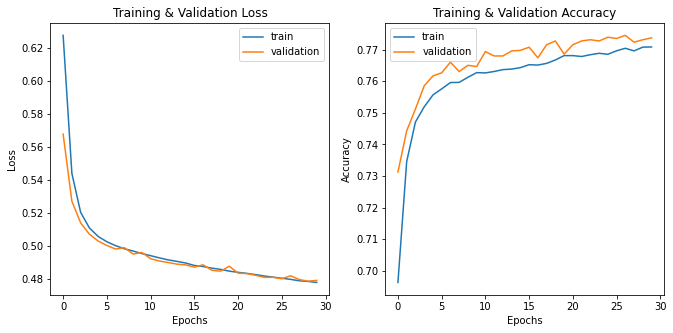

-------------------------
F1:        77.144101
Recall:    78.720569
Precision: 75.629535
Accuracy:  76.671851
------------------
Batch size:  64
-------------------------


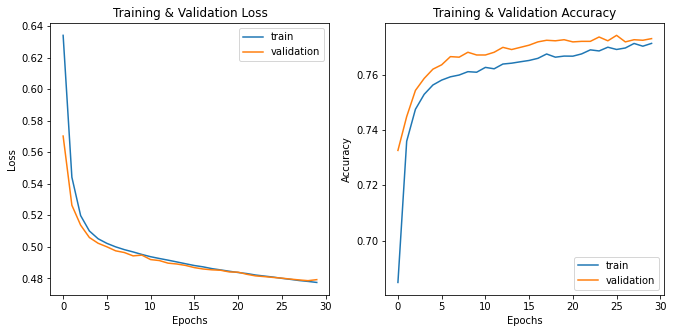

-------------------------
F1:        76.078972
Recall:    73.611728
Precision: 78.717340
Accuracy:  76.849589
------------------
Batch size:  128
-------------------------


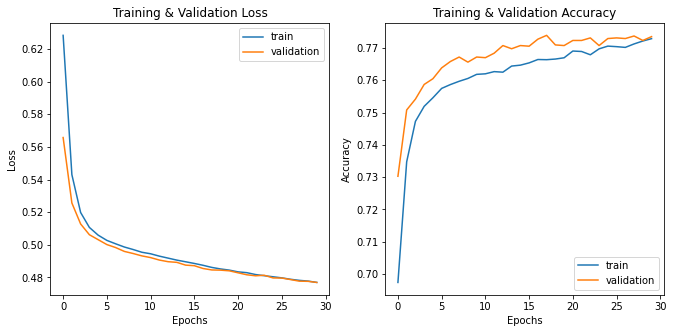

-------------------------
F1:        77.112676
Recall:    77.832075
Precision: 76.406454
Accuracy:  76.894024
------------------
Batch size:  256
-------------------------


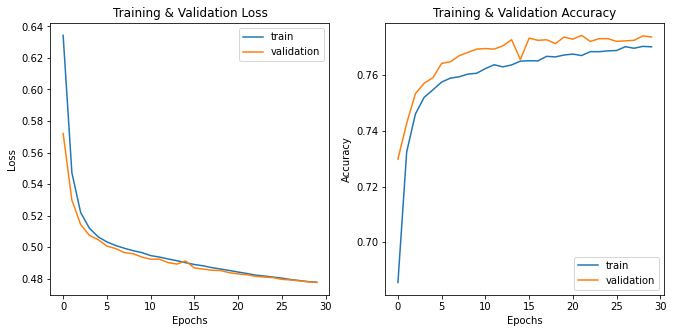

-------------------------
F1:        76.642664
Recall:    75.655264
Precision: 77.656179
Accuracy:  76.938458


In [ ]:
for batch_size in [32, 64, 128, 256]:
  print("------------------")
  print("Batch size: ", batch_size)
  train_loader = DataLoader(train_set, batch_size= batch_size,
                                        shuffle= True)
  val_loader = DataLoader(validation_set, batch_size= batch_size, 
                                        shuffle= False)

  model = SentimentClassifier_2L(input_size=50, hidden_size=250).to(device)

  run_epochs(model,30,show_plot_roc_curve=False,show_plot_cm=False, show_epoch_results=False)

As we can see above, the performances doesn't change significantly for different batch sizes. We will proceed using batch size of 32.

In [ ]:
batch_size=32
train_loader = DataLoader(train_set, batch_size= batch_size,
                                      shuffle= True)
val_loader = DataLoader(validation_set, batch_size= batch_size, 
                                    shuffle= False)

From the above results and further experimentation, we train the following model:
*   2 linear layers + 1 dropout layer
*   Relu
*   Adam optimizer
*   BCEWithLogitsLoss
*   Learning rate: 0.00005
*   Epochs: 100
*   Batch size: 32

Epoch 1 | Train Loss: 0.655 | Val Loss: 0.61 | Train Acc: 66.614 | Val Acc: 72.176
Epoch 2 | Train Loss: 0.581 | Val Loss: 0.556 | Train Acc: 71.972 | Val Acc: 73.44
Epoch 3 | Train Loss: 0.546 | Val Loss: 0.533 | Train Acc: 73.239 | Val Acc: 74.487
Epoch 4 | Train Loss: 0.53 | Val Loss: 0.521 | Train Acc: 74.017 | Val Acc: 74.822
Epoch 5 | Train Loss: 0.52 | Val Loss: 0.514 | Train Acc: 74.633 | Val Acc: 75.415
Epoch 6 | Train Loss: 0.515 | Val Loss: 0.509 | Train Acc: 74.963 | Val Acc: 75.671
Epoch 7 | Train Loss: 0.511 | Val Loss: 0.506 | Train Acc: 75.222 | Val Acc: 75.869
Epoch 8 | Train Loss: 0.508 | Val Loss: 0.503 | Train Acc: 75.445 | Val Acc: 75.987
Epoch 9 | Train Loss: 0.506 | Val Loss: 0.501 | Train Acc: 75.451 | Val Acc: 76.343
Epoch 10 | Train Loss: 0.504 | Val Loss: 0.499 | Train Acc: 75.6 | Val Acc: 76.323
Epoch 11 | Train Loss: 0.502 | Val Loss: 0.498 | Train Acc: 75.837 | Val Acc: 76.481
Epoch 12 | Train Loss: 0.5 | Val Loss: 0.497 | Train Acc: 75.863 | Val Acc: 76.5

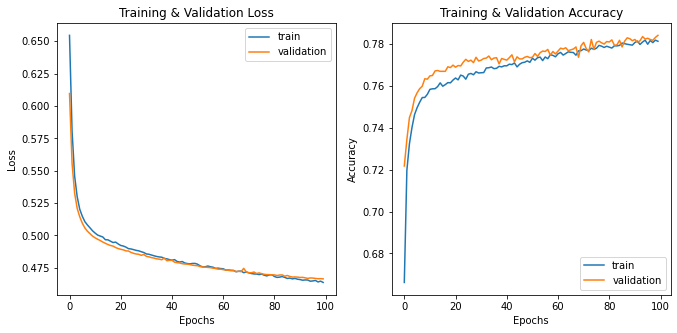

-------------------------
F1:        77.841410
Recall:    78.498445
Precision: 77.195282
Accuracy:  77.649411


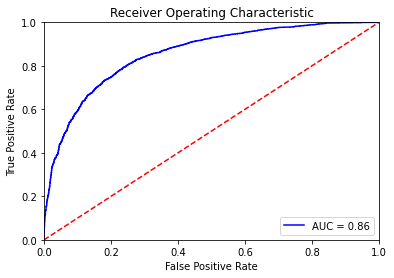

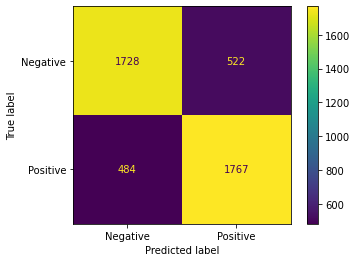

In [ ]:
model = SentimentClassifier_2L_D(input_size=max_seq_len, activation_fn=F.relu, hidden_size=500).to(device)
res = run_epochs(model, num_epochs=100, optimizer=torch.optim.Adam, learning_rate=0.00005,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/50d_2ld_hs500_adam', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/50d_2ld_hs500_adam')

We train the following model:
*   2 linear layers (hidden size = 750)
*   SGD
*   Adam optimizer
*   Learning rate: 0.004
*   Epochs: 160

Epoch 1 | Train Loss: 0.679 | Val Loss: 0.663 | Train Acc: 63.344 | Val Acc: 71.426
Epoch 2 | Train Loss: 0.649 | Val Loss: 0.635 | Train Acc: 71.219 | Val Acc: 70.438
Epoch 3 | Train Loss: 0.622 | Val Loss: 0.61 | Train Acc: 71.625 | Val Acc: 72.235
Epoch 4 | Train Loss: 0.6 | Val Loss: 0.59 | Train Acc: 71.997 | Val Acc: 72.551
Epoch 5 | Train Loss: 0.581 | Val Loss: 0.573 | Train Acc: 72.446 | Val Acc: 73.262
Epoch 6 | Train Loss: 0.567 | Val Loss: 0.561 | Train Acc: 72.672 | Val Acc: 73.519
Epoch 7 | Train Loss: 0.556 | Val Loss: 0.551 | Train Acc: 73.072 | Val Acc: 73.578
Epoch 8 | Train Loss: 0.547 | Val Loss: 0.544 | Train Acc: 73.306 | Val Acc: 73.934
Epoch 9 | Train Loss: 0.541 | Val Loss: 0.538 | Train Acc: 73.634 | Val Acc: 74.013
Epoch 10 | Train Loss: 0.535 | Val Loss: 0.533 | Train Acc: 73.975 | Val Acc: 74.289
Epoch 11 | Train Loss: 0.531 | Val Loss: 0.528 | Train Acc: 74.02 | Val Acc: 74.427
Epoch 12 | Train Loss: 0.527 | Val Loss: 0.525 | Train Acc: 74.252 | Val Acc: 7

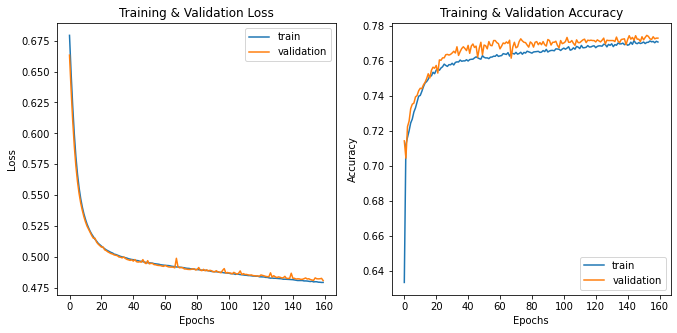

-------------------------
F1:        77.089305
Recall:    77.654376
Precision: 76.532399
Accuracy:  76.916241


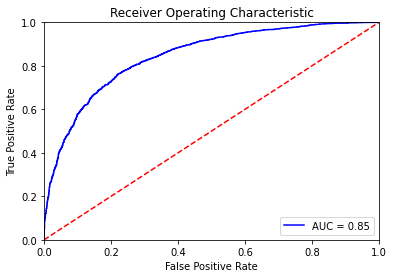

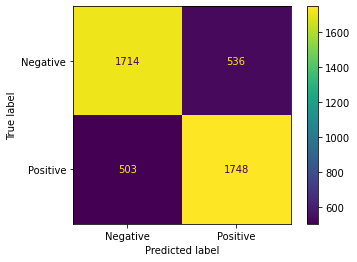

In [ ]:
model = SentimentClassifier_2L(input_size=max_seq_len, activation_fn=F.relu, hidden_size=750).to(device)
res = run_epochs(model, num_epochs=160, optimizer=torch.optim.SGD, learning_rate=0.004,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/50d_2l_hs800_sgd', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/50d_2l_hs800_sgd')

To improve scores we're going to train the models on the 300d GloVe Embeddings.

### Training - 300d GloVe Embeddings

Firstly, we will test our best model from the 50d training, to see it still performs well in the 300d embeddings data.

Epoch 1 | Train Loss: 0.589 | Val Loss: 0.496 | Train Acc: 74.813 | Val Acc: 78.535
Epoch 2 | Train Loss: 0.457 | Val Loss: 0.428 | Train Acc: 79.824 | Val Acc: 81.694
Epoch 3 | Train Loss: 0.414 | Val Loss: 0.403 | Train Acc: 81.689 | Val Acc: 82.721
Epoch 4 | Train Loss: 0.396 | Val Loss: 0.393 | Train Acc: 82.645 | Val Acc: 83.017
Epoch 5 | Train Loss: 0.385 | Val Loss: 0.385 | Train Acc: 83.21 | Val Acc: 83.254
Epoch 6 | Train Loss: 0.379 | Val Loss: 0.382 | Train Acc: 83.173 | Val Acc: 83.412
Epoch 7 | Train Loss: 0.374 | Val Loss: 0.378 | Train Acc: 83.588 | Val Acc: 83.432
Epoch 8 | Train Loss: 0.372 | Val Loss: 0.377 | Train Acc: 83.757 | Val Acc: 83.669
Epoch 9 | Train Loss: 0.369 | Val Loss: 0.375 | Train Acc: 83.963 | Val Acc: 83.531
Epoch 10 | Train Loss: 0.367 | Val Loss: 0.375 | Train Acc: 83.94 | Val Acc: 83.373
Epoch 11 | Train Loss: 0.366 | Val Loss: 0.374 | Train Acc: 84.059 | Val Acc: 83.748
Epoch 12 | Train Loss: 0.364 | Val Loss: 0.374 | Train Acc: 84.014 | Val Acc

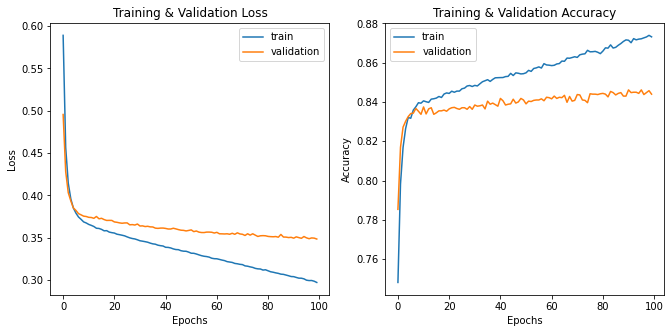

-------------------------
F1:        85.501859
Recall:    86.850289
Precision: 84.194660
Accuracy:  85.269940


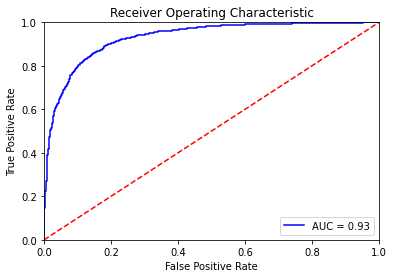

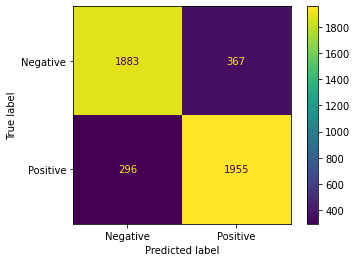

In [ ]:
max_seq_len=300
model = SentimentClassifier_2L_D(input_size=max_seq_len, activation_fn=F.relu, hidden_size=500).to(device)
res = run_epochs(model, num_epochs=100, optimizer=torch.optim.Adam, learning_rate=0.00005,
                 train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_50d_adam_model', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_50d_adam_model')

Epoch 1 | Train Loss: 0.689 | Val Loss: 0.684 | Train Acc: 63.017 | Val Acc: 69.708
Epoch 2 | Train Loss: 0.678 | Val Loss: 0.672 | Train Acc: 72.347 | Val Acc: 73.657
Epoch 3 | Train Loss: 0.664 | Val Loss: 0.656 | Train Acc: 73.606 | Val Acc: 74.506
Epoch 4 | Train Loss: 0.646 | Val Loss: 0.636 | Train Acc: 74.446 | Val Acc: 74.862
Epoch 5 | Train Loss: 0.623 | Val Loss: 0.611 | Train Acc: 74.703 | Val Acc: 75.158
Epoch 6 | Train Loss: 0.598 | Val Loss: 0.585 | Train Acc: 75.16 | Val Acc: 75.889
Epoch 7 | Train Loss: 0.572 | Val Loss: 0.56 | Train Acc: 75.696 | Val Acc: 75.968
Epoch 8 | Train Loss: 0.548 | Val Loss: 0.537 | Train Acc: 76.232 | Val Acc: 76.955
Epoch 9 | Train Loss: 0.527 | Val Loss: 0.518 | Train Acc: 76.83 | Val Acc: 77.31
Epoch 10 | Train Loss: 0.509 | Val Loss: 0.502 | Train Acc: 77.31 | Val Acc: 77.666
Epoch 11 | Train Loss: 0.494 | Val Loss: 0.488 | Train Acc: 77.925 | Val Acc: 78.653
Epoch 12 | Train Loss: 0.481 | Val Loss: 0.476 | Train Acc: 78.599 | Val Acc: 7

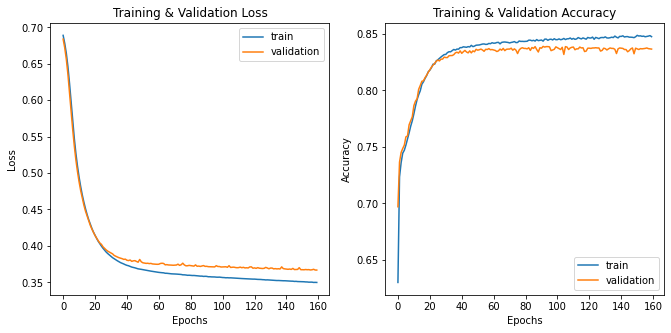

-------------------------
F1:        83.955556
Recall:    83.918259
Precision: 83.992886
Accuracy:  83.959120


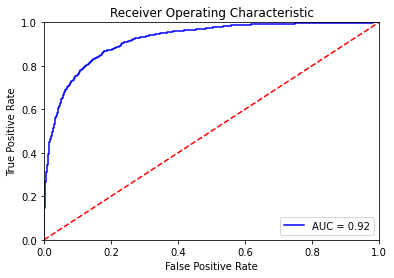

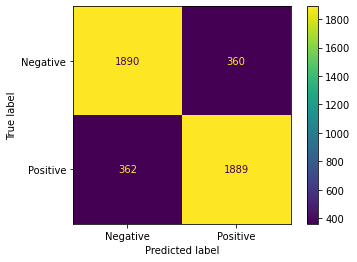

In [ ]:
model = SentimentClassifier_2L(input_size=max_seq_len, activation_fn=F.relu, hidden_size=750).to(device)
res = run_epochs(model, num_epochs=160, optimizer=torch.optim.SGD, learning_rate=0.004,
                 train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_50d_sgd_model', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_50d_sgd_model')

The results from training our best models on 50d on the 300d data are not very good since there is much overfitting. A grid search will be done to guide the experiments that will be done on the 300d embeddings. 

-----------------
#0 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: relu | Init Hidden Size: 200
-------------------------


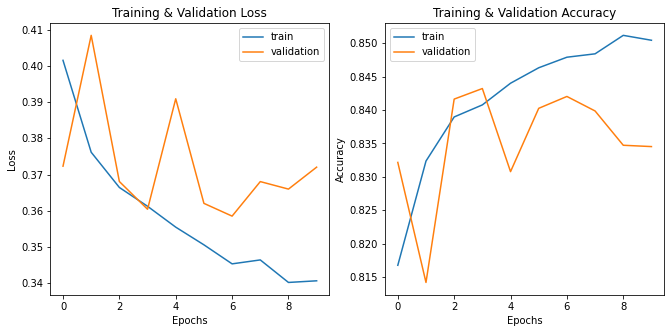

-------------------------
F1:        83.732719
Recall:    80.719680
Precision: 86.979416
Accuracy:  84.314597
-----------------
#1 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: relu | Init Hidden Size: 500
-------------------------


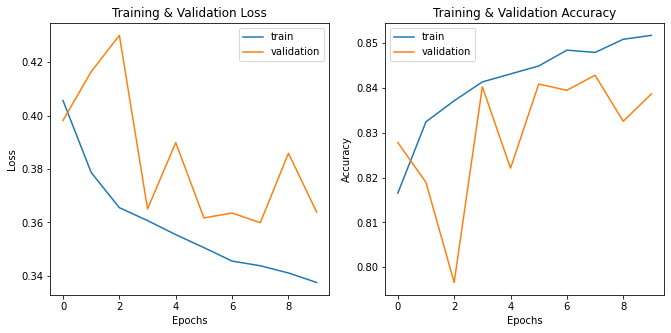

-------------------------
F1:        83.799908
Recall:    81.119502
Precision: 86.663503
Accuracy:  84.314597
-----------------
#2 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: relu | Init Hidden Size: 200
-------------------------


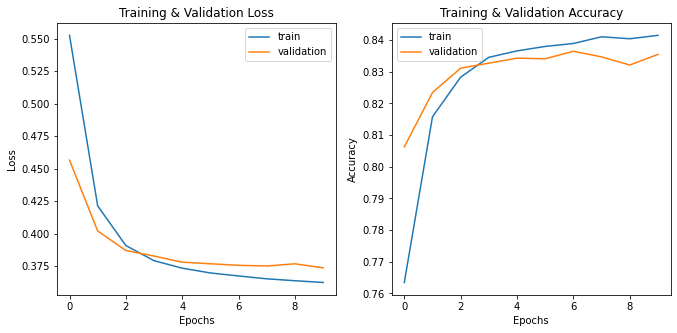

-------------------------
F1:        83.554377
Recall:    83.962683
Precision: 83.150022
Accuracy:  83.470340
-----------------
#3 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: relu | Init Hidden Size: 500
-------------------------


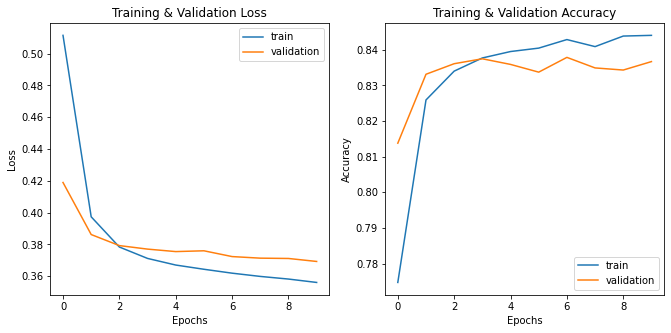

-------------------------
F1:        83.692992
Recall:    83.562861
Precision: 83.823529
Accuracy:  83.714730
-----------------
#4 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: leaky_relu | Init Hidden Size: 200
-------------------------


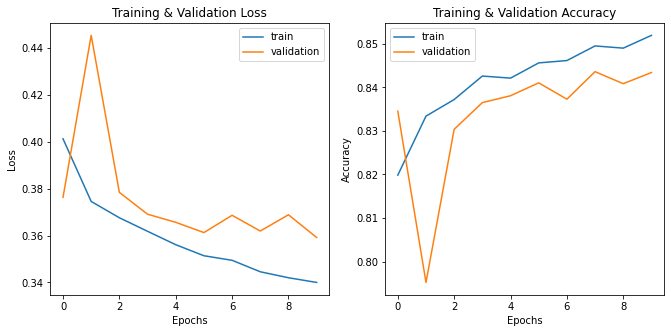

-------------------------
F1:        84.832451
Recall:    85.473123
Precision: 84.201313
Accuracy:  84.714508
-----------------
#5 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: leaky_relu | Init Hidden Size: 500
-------------------------


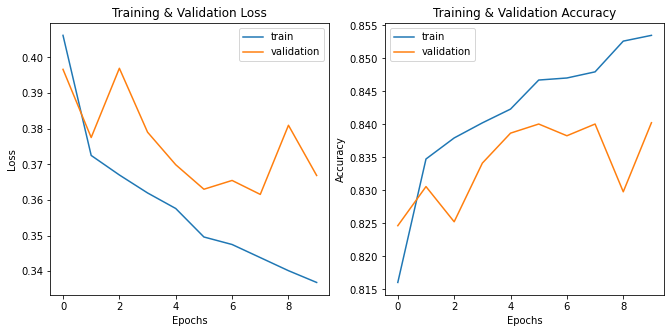

-------------------------
F1:        83.848797
Recall:    81.297201
Precision: 86.565752
Accuracy:  84.336814
-----------------
#6 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: leaky_relu | Init Hidden Size: 200
-------------------------


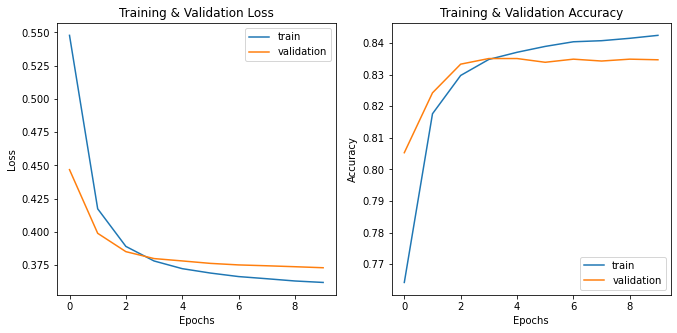

-------------------------
F1:        83.467742
Recall:    82.763216
Precision: 84.184365
Accuracy:  83.603644
-----------------
#7 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L | Activation Function: leaky_relu | Init Hidden Size: 500
-------------------------


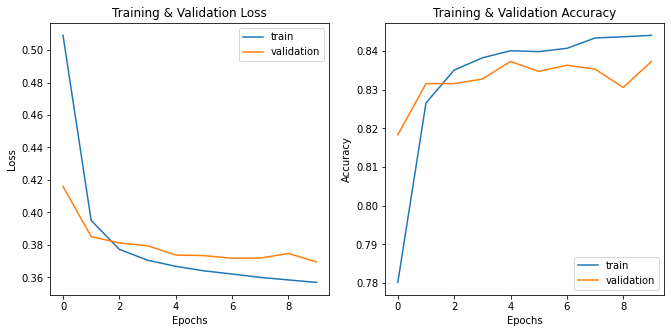

-------------------------
F1:        83.642044
Recall:    83.251888
Precision: 84.035874
Accuracy:  83.714730
-----------------
#8 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: relu | Init Hidden Size: 200
-------------------------


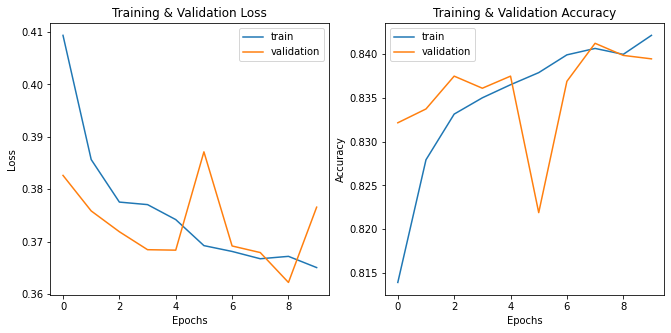

-------------------------
F1:        84.612124
Recall:    88.671701
Precision: 80.907985
Accuracy:  83.870251
-----------------
#9 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: relu | Init Hidden Size: 500
-------------------------


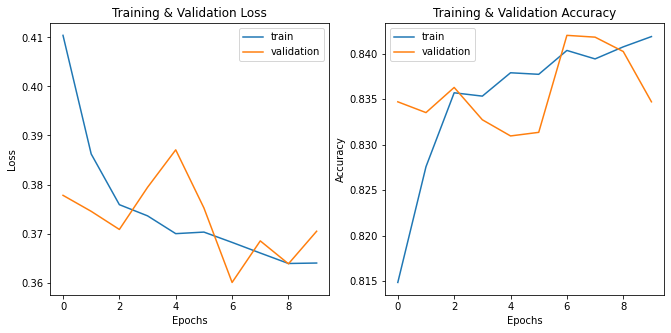

-------------------------
F1:        83.255814
Recall:    79.520213
Precision: 87.359688
Accuracy:  84.003555
-----------------
#10 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: relu | Init Hidden Size: 200
-------------------------


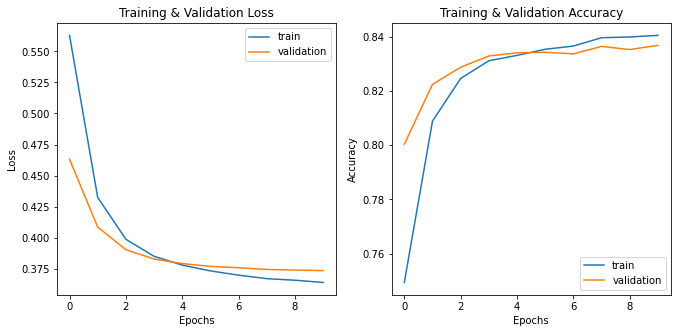

-------------------------
F1:        83.681089
Recall:    84.629054
Precision: 82.754127
Accuracy:  83.492557
-----------------
#11 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: relu | Init Hidden Size: 500
-------------------------


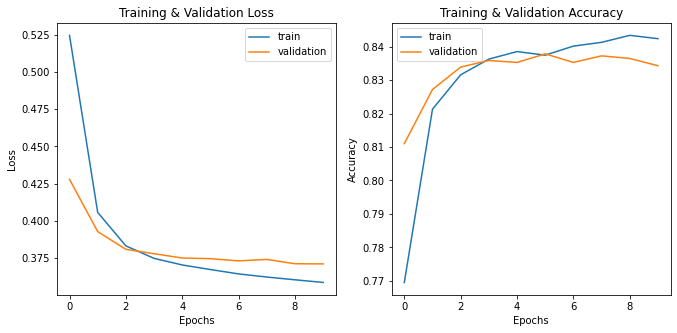

-------------------------
F1:        83.197464
Recall:    81.608174
Precision: 84.849885
Accuracy:  83.514774
-----------------
#12 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: leaky_relu | Init Hidden Size: 200
-------------------------


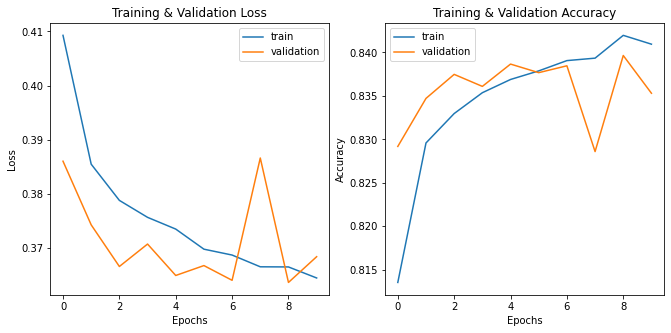

-------------------------
F1:        84.269663
Recall:    83.296313
Precision: 85.266030
Accuracy:  84.447900
-----------------
#13 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: leaky_relu | Init Hidden Size: 500
-------------------------


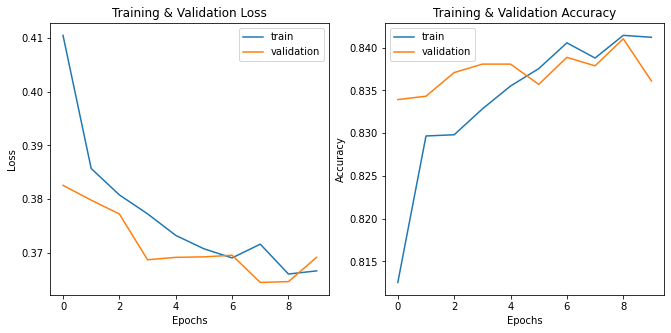

-------------------------
F1:        83.603933
Recall:    81.208352
Precision: 86.145146
Accuracy:  84.070207
-----------------
#14 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: leaky_relu | Init Hidden Size: 200
-------------------------


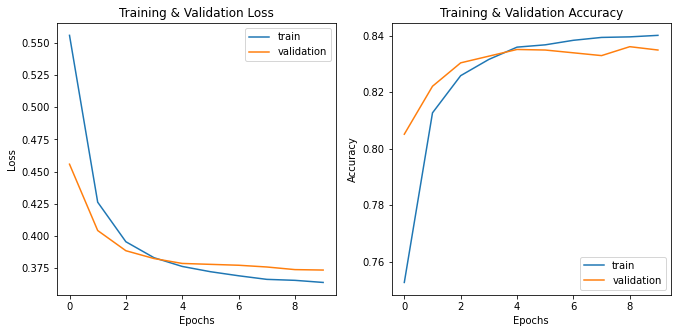

-------------------------
F1:        83.677959
Recall:    84.495780
Precision: 82.875817
Accuracy:  83.514774
-----------------
#15 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_2L_D | Activation Function: leaky_relu | Init Hidden Size: 500
-------------------------


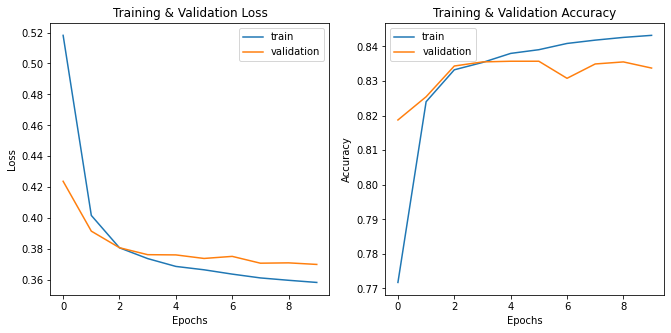

-------------------------
F1:        83.464567
Recall:    82.407819
Precision: 84.548769
Accuracy:  83.670295
-----------------
#16 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: relu | Init Hidden Size: 512
-------------------------


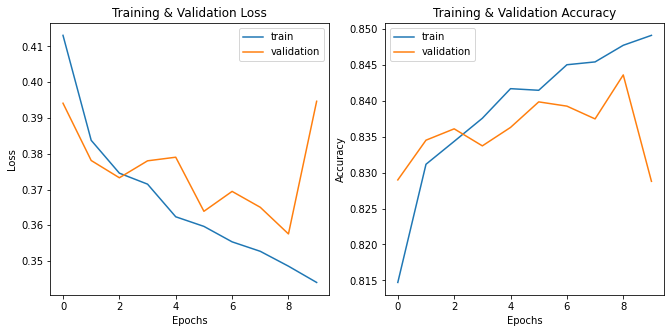

-------------------------
F1:        82.096070
Recall:    75.166593
Precision: 90.432924
Accuracy:  83.603644
-----------------
#17 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: relu | Init Hidden Size: 1024
-------------------------


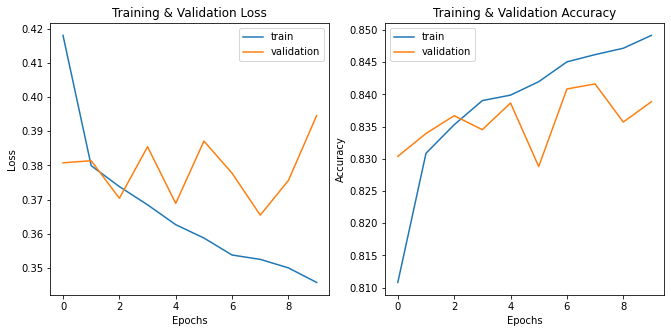

-------------------------
F1:        84.899329
Recall:    89.915593
Precision: 80.413190
Accuracy:  84.003555
-----------------
#18 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: relu | Init Hidden Size: 512
-------------------------


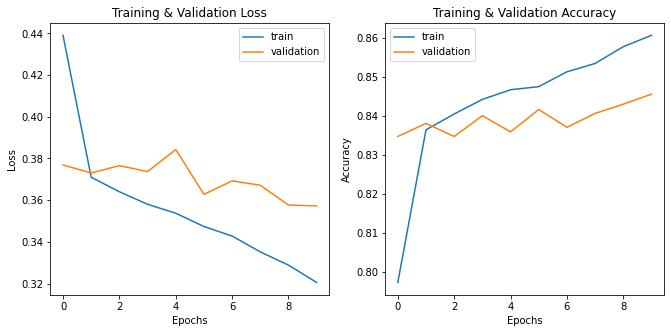

-------------------------
F1:        84.901828
Recall:    83.562861
Precision: 86.284404
Accuracy:  85.136636
-----------------
#19 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: relu | Init Hidden Size: 1024
-------------------------


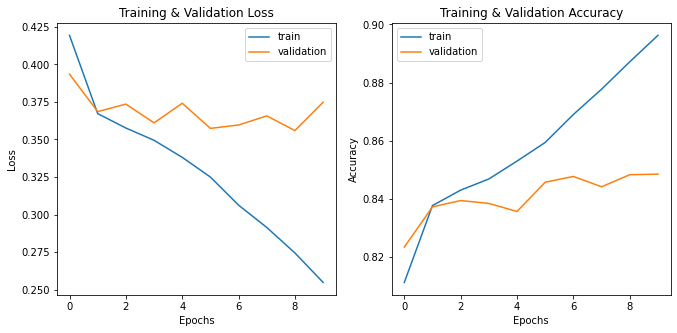

-------------------------
F1:        85.105448
Recall:    86.050644
Precision: 84.180791
Accuracy:  84.936681
-----------------
#20 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: leaky_relu | Init Hidden Size: 512
-------------------------


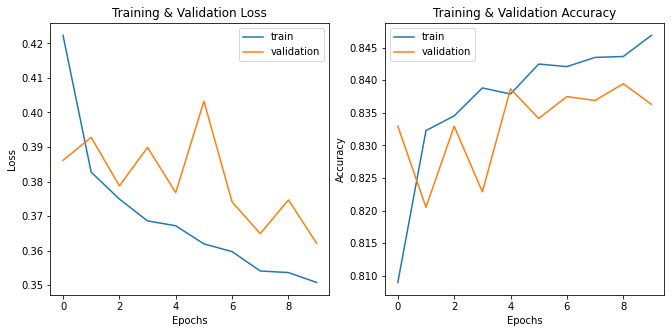

-------------------------
F1:        83.860759
Recall:    82.407819
Precision: 85.365854
Accuracy:  84.136858
-----------------
#21 | Batch Size: 32 | LR: 0.01 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: leaky_relu | Init Hidden Size: 1024
-------------------------


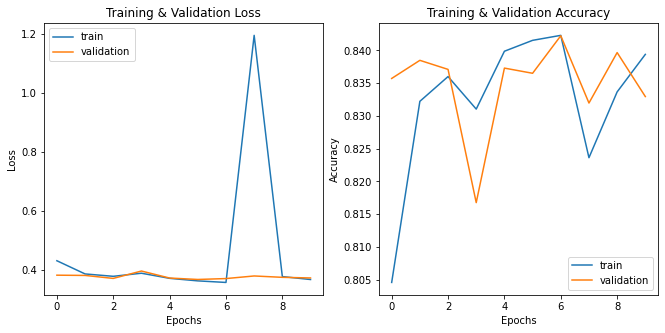

-------------------------
F1:        83.989980
Recall:    81.919147
Precision: 86.168224
Accuracy:  84.381249
-----------------
#22 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: leaky_relu | Init Hidden Size: 512
-------------------------


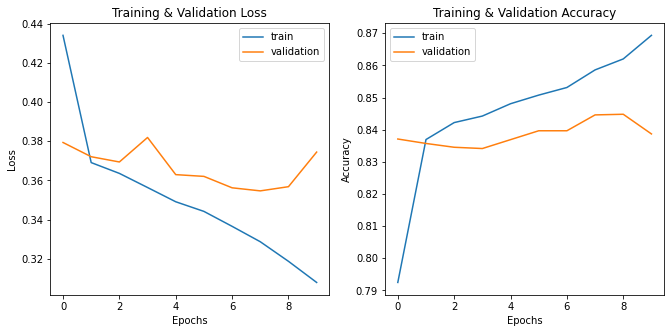

-------------------------
F1:        83.486455
Recall:    78.720569
Precision: 88.866600
Accuracy:  84.425683
-----------------
#23 | Batch Size: 32 | LR: 0.0001 | Optimizer: Adam
Model: SentimentClassifier_5L | Activation Function: leaky_relu | Init Hidden Size: 1024
-------------------------


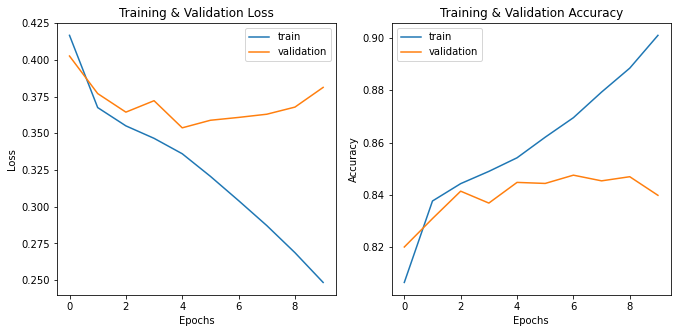

-------------------------
F1:        85.364308
Recall:    89.782319
Precision: 81.360709
Accuracy:  84.603421


In [ ]:
max_seq_len=300
models = [SentimentClassifier_2L, SentimentClassifier_2L_D, SentimentClassifier_5L]
activation_functions = [F.relu, F.leaky_relu]
optimizers = [torch.optim.Adam]
learning_rates = [1e-2,1e-4]

grid = list(product(models, activation_functions, optimizers, learning_rates))
grid_results300 = []
counter = 0
for model_class, activation_fn, opt, lr in grid:
  if model_class == SentimentClassifier_5L:
    hidden_sizes = [512,1024]
  else:
    hidden_sizes = [200, 500]
  for hs in hidden_sizes:
    model_info = [counter, batch_size, model_class.__name__, activation_fn, opt, lr, hs]
    print('-----------------')
    print(f'#{counter} | Batch Size: {batch_size} | LR: {lr} | Optimizer: {opt.__name__}')
    print(f'Model: {model_class.__name__} | Activation Function: {activation_fn.__name__} | Init Hidden Size: {hs}')

    model = model_class(input_size=300, activation_fn=activation_fn, hidden_size=hs).to(device)
    res = run_epochs(model, num_epochs=10, optimizer=opt, learning_rate=lr,
                show_epoch_results=False, show_plot_cm=False, show_plot_roc_curve=False, return_results=True,
                train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300)
    grid_results300.append(model_info+res)
    counter += 1

It can be noticed that the most promiment model seem to be the SentimentClassifier_2L_D, so it will be fine tuned for Adam and SGD.

Epoch 1 | Train Loss: 0.675 | Val Loss: 0.653 | Train Acc: 65.765 | Val Acc: 75.415
Epoch 2 | Train Loss: 0.626 | Val Loss: 0.599 | Train Acc: 74.779 | Val Acc: 76.461
Epoch 3 | Train Loss: 0.575 | Val Loss: 0.552 | Train Acc: 75.992 | Val Acc: 77.172
Epoch 4 | Train Loss: 0.534 | Val Loss: 0.517 | Train Acc: 76.907 | Val Acc: 77.784
Epoch 5 | Train Loss: 0.506 | Val Loss: 0.493 | Train Acc: 77.759 | Val Acc: 78.535
Epoch 6 | Train Loss: 0.484 | Val Loss: 0.474 | Train Acc: 78.63 | Val Acc: 79.167
Epoch 7 | Train Loss: 0.468 | Val Loss: 0.459 | Train Acc: 79.096 | Val Acc: 80.174
Epoch 8 | Train Loss: 0.455 | Val Loss: 0.447 | Train Acc: 79.838 | Val Acc: 80.786
Epoch 9 | Train Loss: 0.443 | Val Loss: 0.437 | Train Acc: 80.278 | Val Acc: 80.964
Epoch 10 | Train Loss: 0.434 | Val Loss: 0.428 | Train Acc: 80.902 | Val Acc: 81.161
Epoch 11 | Train Loss: 0.427 | Val Loss: 0.422 | Train Acc: 81.054 | Val Acc: 81.734
Epoch 12 | Train Loss: 0.42 | Val Loss: 0.416 | Train Acc: 81.353 | Val Acc

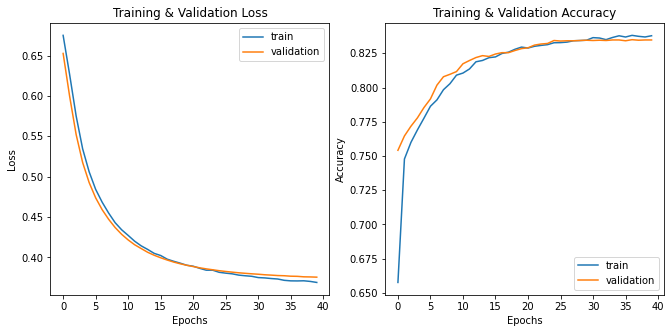

-------------------------
F1:        83.154602
Recall:    82.674367
Precision: 83.640449
Accuracy:  83.248167


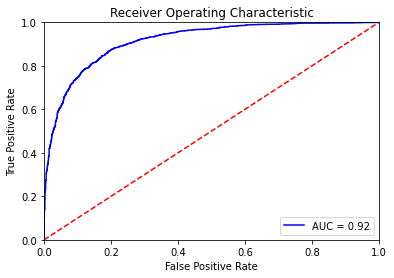

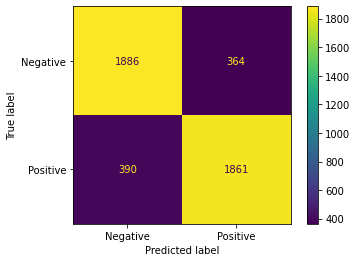

In [ ]:
model = SentimentClassifier_2L_D(input_size=300, activation_fn=F.relu, hidden_size=1200, dr=0.6).to(device)
res = run_epochs(model, num_epochs=40, optimizer=torch.optim.Adam, learning_rate=0.00001,
                 train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/2ld_1200_adam_new', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/2ld_1200_adam_new')

-------------------------


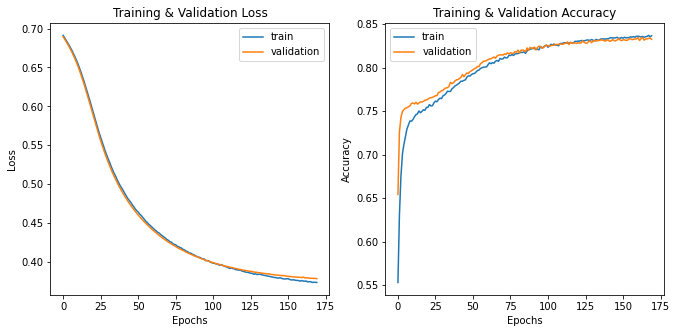

-------------------------
F1:        83.396310
Recall:    83.340737
Precision: 83.451957
Accuracy:  83.403688


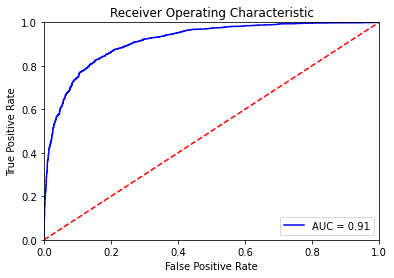

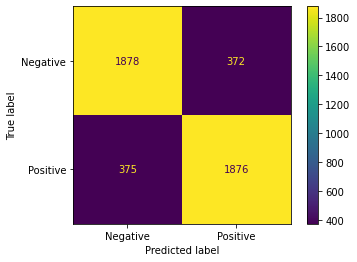

In [ ]:
model = SentimentClassifier_2L_D(input_size=300, activation_fn=F.relu, hidden_size=1000).to(device)
res = run_epochs(model, num_epochs=170, optimizer=torch.optim.SGD, learning_rate=0.001,
                 show_epoch_results=False,
                 train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/2ld_hs1000_sgd_new', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/2ld_hs1000_sgd_new')

The results above seem fine, but I'd like to explore the other two architectures suggested on the models section (SentimentClassifier_2L, SentimentClassifier_5L).

Epoch 1 | Train Loss: 0.671 | Val Loss: 0.643 | Train Acc: 67.486 | Val Acc: 75.434
Epoch 2 | Train Loss: 0.608 | Val Loss: 0.576 | Train Acc: 75.812 | Val Acc: 76.915
Epoch 3 | Train Loss: 0.549 | Val Loss: 0.526 | Train Acc: 76.87 | Val Acc: 77.824
Epoch 4 | Train Loss: 0.508 | Val Loss: 0.492 | Train Acc: 78.004 | Val Acc: 78.574
Epoch 5 | Train Loss: 0.479 | Val Loss: 0.468 | Train Acc: 78.944 | Val Acc: 79.621
Epoch 6 | Train Loss: 0.459 | Val Loss: 0.45 | Train Acc: 79.773 | Val Acc: 80.45
Epoch 7 | Train Loss: 0.443 | Val Loss: 0.436 | Train Acc: 80.425 | Val Acc: 81.319
Epoch 8 | Train Loss: 0.43 | Val Loss: 0.425 | Train Acc: 81.119 | Val Acc: 81.694
Epoch 9 | Train Loss: 0.42 | Val Loss: 0.417 | Train Acc: 81.618 | Val Acc: 82.148
Epoch 10 | Train Loss: 0.412 | Val Loss: 0.41 | Train Acc: 81.991 | Val Acc: 82.267
Epoch 11 | Train Loss: 0.405 | Val Loss: 0.404 | Train Acc: 82.267 | Val Acc: 82.366
Epoch 12 | Train Loss: 0.4 | Val Loss: 0.401 | Train Acc: 82.544 | Val Acc: 82.9

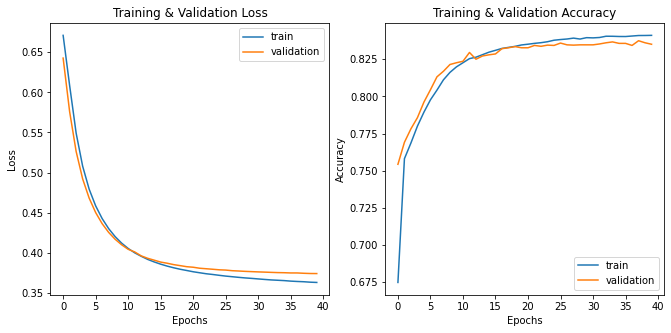

-------------------------
F1:        83.430103
Recall:    82.985340
Precision: 83.879659
Accuracy:  83.514774


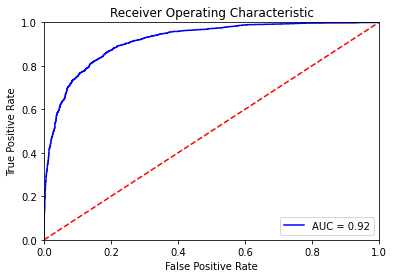

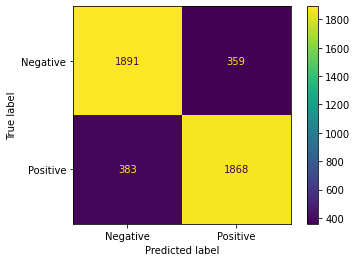

In [ ]:
model = SentimentClassifier_2L(input_size=300, activation_fn=F.relu, hidden_size=850).to(device)
res = run_epochs(model, num_epochs=40, optimizer=torch.optim.Adam, learning_rate=0.00001,
                 train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_2l_hs850_adam', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_2l_hs850_adam')

Epoch 1 | Train Loss: 0.693 | Val Loss: 0.693 | Train Acc: 50.01 | Val Acc: 50.0
Epoch 2 | Train Loss: 0.692 | Val Loss: 0.692 | Train Acc: 50.049 | Val Acc: 50.296
Epoch 3 | Train Loss: 0.691 | Val Loss: 0.69 | Train Acc: 54.928 | Val Acc: 60.466
Epoch 4 | Train Loss: 0.689 | Val Loss: 0.687 | Train Acc: 65.511 | Val Acc: 68.938
Epoch 5 | Train Loss: 0.685 | Val Loss: 0.682 | Train Acc: 71.326 | Val Acc: 73.578
Epoch 6 | Train Loss: 0.678 | Val Loss: 0.674 | Train Acc: 74.333 | Val Acc: 75.434
Epoch 7 | Train Loss: 0.67 | Val Loss: 0.665 | Train Acc: 75.504 | Val Acc: 75.75
Epoch 8 | Train Loss: 0.659 | Val Loss: 0.653 | Train Acc: 75.792 | Val Acc: 76.066
Epoch 9 | Train Loss: 0.645 | Val Loss: 0.637 | Train Acc: 76.08 | Val Acc: 76.56
Epoch 10 | Train Loss: 0.627 | Val Loss: 0.618 | Train Acc: 76.263 | Val Acc: 76.836
Epoch 11 | Train Loss: 0.608 | Val Loss: 0.597 | Train Acc: 76.54 | Val Acc: 76.994
Epoch 12 | Train Loss: 0.586 | Val Loss: 0.575 | Train Acc: 76.737 | Val Acc: 77.21

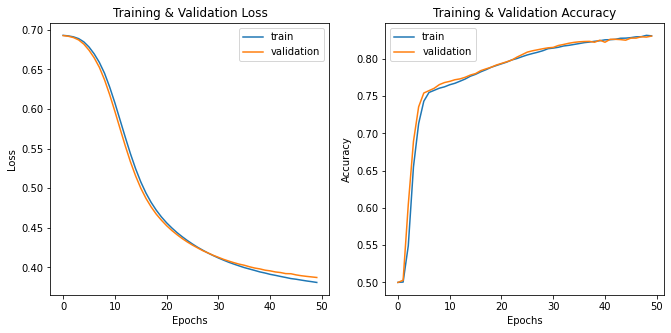

-------------------------
F1:        82.792571
Recall:    82.185695
Precision: 83.408476
Accuracy:  82.914908


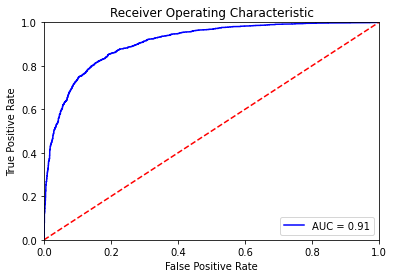

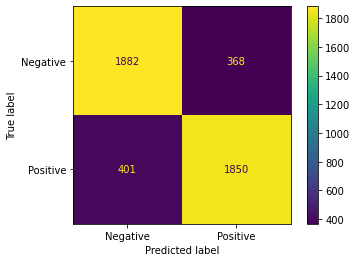

In [ ]:
model = SentimentClassifier_5L(input_size=max_seq_len, activation_fn=F.relu, hidden_size=880).to(device)
res = run_epochs(model, num_epochs=50, optimizer=torch.optim.AdamW, learning_rate=0.0000008,
                 train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                  save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_5ld_hs880_adam', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/300d_5ld_hs880_adam')

## Evaluation

### Best Model Selection

Finally, the selected model is SentimentClassifier_2L_D. It has 2 linear layers (1 hidden with size 1000) with ReLU and a dropout layer (p=0.25) as the activation function. The loss function is BCEWithLogitsLoss, which is a sigmoid function followed by BCELoss. The optimizer is SGD with learning rate 0.001 and weight decay (L2 penalty) 0.00001. Finally, the model is trianed for 170 epochs.

-------------------------


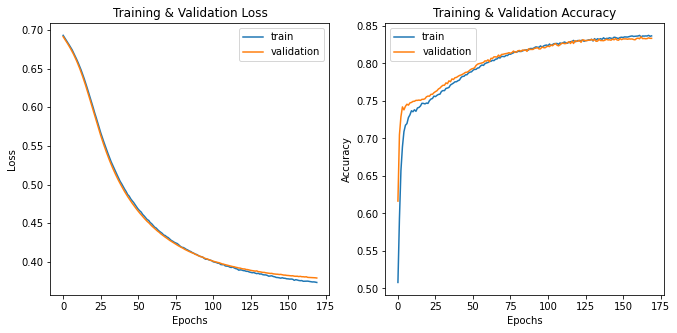

-------------------------
F1:        83.333333
Recall:    82.852066
Precision: 83.820225
Accuracy:  83.425905


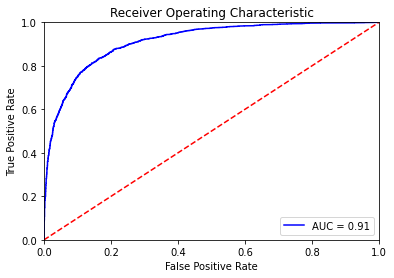

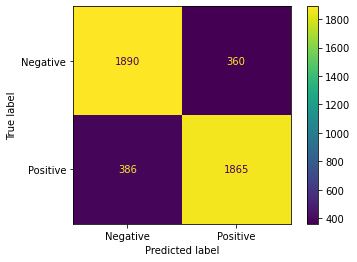

In [ ]:
model = SentimentClassifier_2L_D(input_size=300, activation_fn=F.relu, hidden_size=1000).to(device)
res = run_epochs(model, num_epochs=170, optimizer=torch.optim.SGD, learning_rate=0.001,
                 show_epoch_results=False,
                 train_loader=train_loader300, val_loader=val_loader300, test_loader=test_loader300,
                 save_plots='/content/drive/My Drive/Colab Notebooks/data/outputs/final_model', 
                 save_model='/content/drive/My Drive/Colab Notebooks/data/outputs/final_model')

### Test the model

To run the model on other data, the following steps should be done:


1.   Load libraries/functions required
  

*   Run the section [Libraries & Connnection](#libraries)
* Run the sectionn [functions for data preparation](#dataprep)
* Run the section [functions for training](#trainprep)



2.   Load data & Model
3.   Run predictions



In [ ]:
# Try it with hidden test data
path_to_data = 'path/to/test/data'
path_to_model = 'path/final_model.pt'

# Data Preparation

df = prep_data(path_to_data)
X_hidden_test = df['review']

X_hidden_test_glove = pd.DataFrame(X_hidden_test).progress_apply(glovify300, axis=1)
X_hidden_test_final = torch.tensor(X_hidden_test_glove.to_list())
y_hidden_test_final = torch.squeeze(torch.from_numpy(df['rating'].to_numpy()).float())
hidden_test_set = TensorDataset(X_hidden_test_final, y_hidden_test_final)
hidden_test_loader = DataLoader(hidden_test_set, 
                                batch_size= len(hidden_test_set), 
                                shuffle= False)

# Load Model
final_model = torch.jit.load(path_to_model) 
final_model.eval()

# Predictions & Results
test(final_model,hidden_test_loader,show_plot_roc_curve=True,show_plot_cm=True)

## References

*   Pytorch Documentation
*   https://learn.microsoft.com/en-us/windows/ai/windows-ml/tutorials/pytorch-analysis-train-model
*   https://www.kaggle.com/getting-started/251213
*   https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

